In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
bikeDF = pd.read_csv("dataSet/bike_train.csv")
print(bikeDF.shape)
bikeDF.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bikeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
bikeDF["datetime"] = bikeDF.datetime.apply(pd.to_datetime)

bikeDF["year"] = bikeDF.datetime.apply(lambda x : x.year)
bikeDF["month"] = bikeDF.datetime.apply(lambda x : x.month)
bikeDF["day"] = bikeDF.datetime.apply(lambda x : x.day)
bikeDF["hour"] = bikeDF.datetime.apply(lambda x : x.hour)


bikeDF.drop(["casual","registered","datetime"], axis = 1, inplace = True)
bikeDF.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


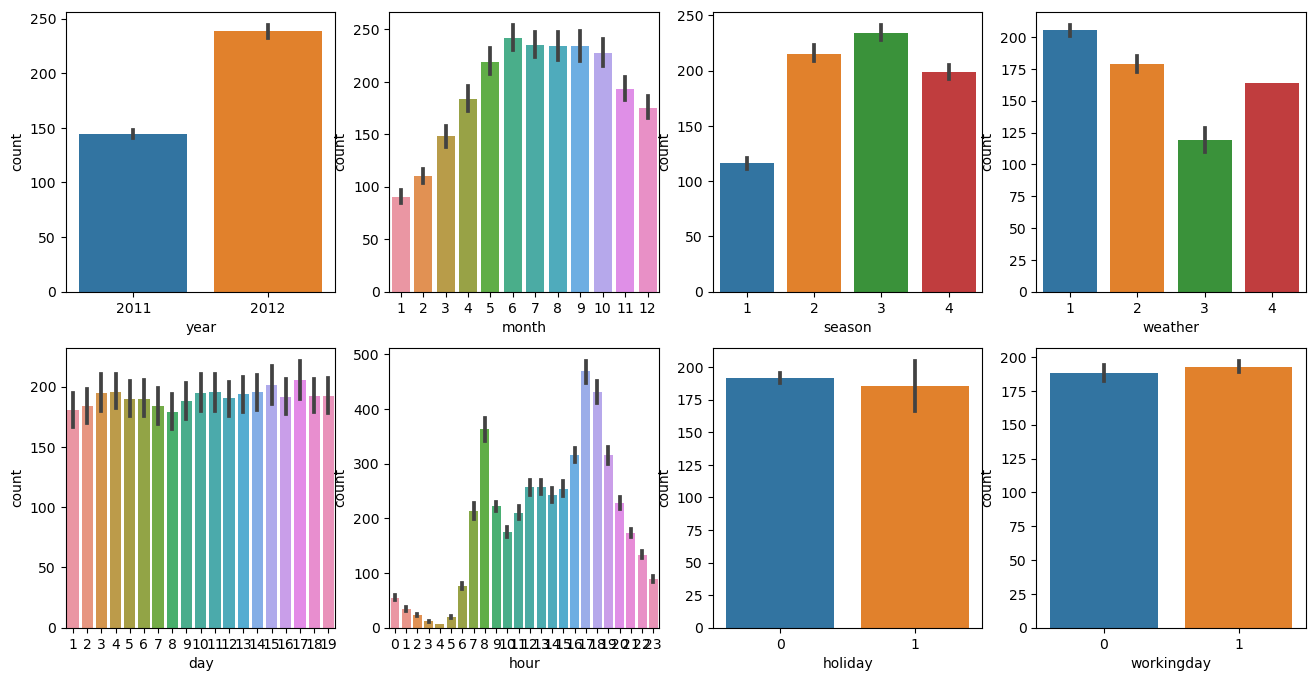

In [5]:
fig, axs = plt.subplots(figsize = (16,8), ncols = 4, nrows = 2)

cat_features = ["year","month","season","weather","day","hour","holiday","workingday"]

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x = feature, y = "count", data = bikeDF, ax = axs[row][col])

In [12]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print(f"RMSLE : {rmsle_val : .3f}, RMSE : {rmse_val : .3f}, MAE : {mae_val : .3f}")

In [15]:
y_target = bikeDF["count"]
X_features = bikeDF.drop(["count"], axis = 1)

lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

lr.fit(X_train, y_train)
pred = lr.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE :  1.165, RMSE :  140.900, MAE :  105.924


In [17]:
def get_top_error_data(y_test, pred, n_tops = 5):
    resultDF = pd.DataFrame(y_test.values, columns = ["real_count"])
    resultDF["predicted_count"] = np.round(pred)
    resultDF["diff"] = np.abs(resultDF["real_count"] - resultDF["predicted_count"])
    
    print(resultDF.sort_values("diff", ascending = False)[:n_tops])

In [18]:
get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

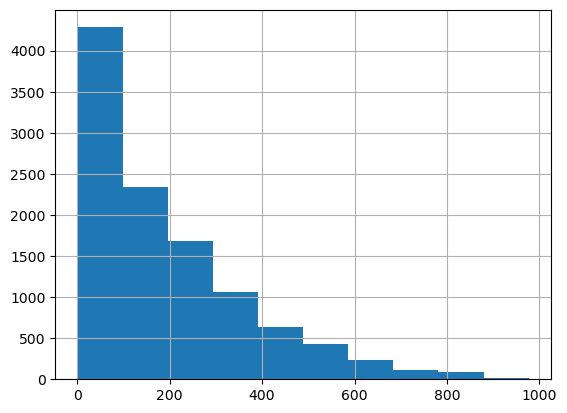

In [19]:
y_target.hist()

<AxesSubplot:>

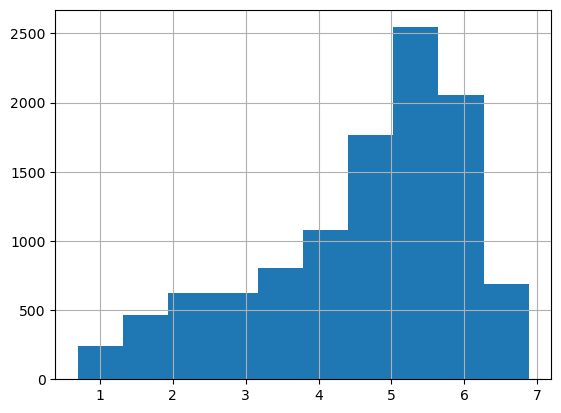

In [20]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [22]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE :  1.017, RMSE :  162.594, MAE :  109.286


In [23]:
get_top_error_data(y_test_exp, pred_exp)

      real_count  predicted_count   diff
2199       201.0            913.0  712.0
3151       798.0            114.0  684.0
2314       766.0             96.0  670.0
412        745.0             78.0  667.0
2003       770.0            106.0  664.0


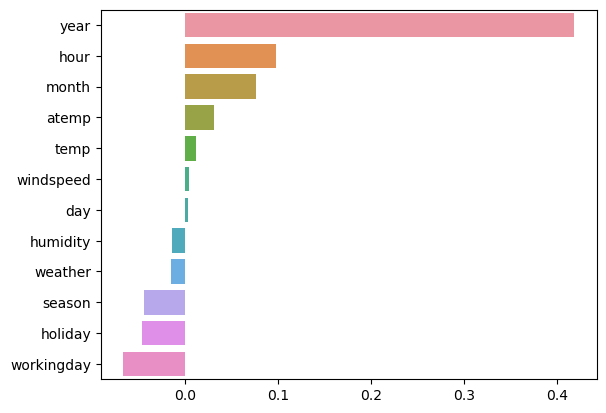

In [27]:
coef = pd.Series(lr.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)
plt.savefig("log_transform.tif", format = "tif", dpi = 300, bbox_inches = "tight")

In [29]:
df = pd.get_dummies(X_features, columns = ["year","month","day","hour","holiday","workingday","season","weather"])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df, y_target_log, test_size = 0.3, random_state = 0)

In [34]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print("###", model.__class__.__name__, "###")
    evaluate_regr(y_test, pred)
    
lr = LinearRegression()
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 0.01)

for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

### LinearRegression ###
RMSLE :  0.590, RMSE :  97.687, MAE :  63.382
### Ridge ###
RMSLE :  0.590, RMSE :  98.529, MAE :  63.893
### Lasso ###
RMSLE :  0.635, RMSE :  113.219, MAE :  72.803


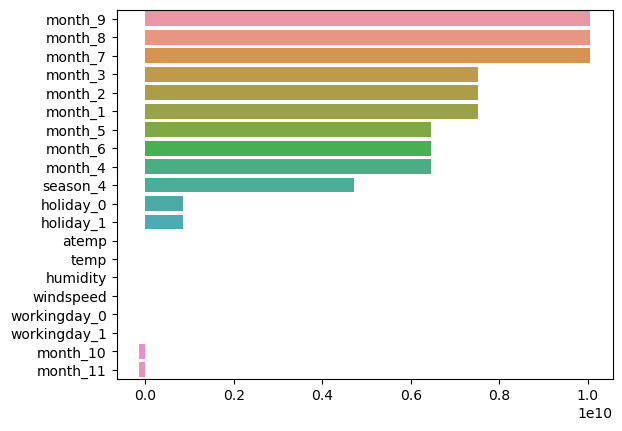

In [36]:
coef = pd.Series(lr.coef_, index = df.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x = coef_sort.values, y = coef_sort.index)
plt.savefig("log_transform.tif", format = "tif", dpi = 300, bbox_inches = "tight")

In [40]:
rf = RandomForestRegressor(n_estimators = 500)
gbm = GradientBoostingRegressor(n_estimators = 500)
xgb = XGBRegressor(n_estimators = 500)
lgbm = LGBMRegressor(n_estimators = 500)

for model in [rf, gbm, xgb, lgbm]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1 = True)

### RandomForestRegressor ###
RMSLE :  0.353, RMSE :  50.250, MAE :  31.074
### GradientBoostingRegressor ###
RMSLE :  0.330, RMSE :  53.361, MAE :  32.752
### XGBRegressor ###
RMSLE :  0.342, RMSE :  51.732, MAE :  31.251
### LGBMRegressor ###
RMSLE :  0.319, RMSE :  47.215, MAE :  29.029
